In [1]:
import cv2
import shutil
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import seaborn as sns
from scipy.io import loadmat
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

In [2]:
PATH_data = 'dataset/'
IMG_PATH_data = PATH_data+'images/'
ANN_PATH_data = PATH_data+'annotations/'
IMG_RESIZE_PATH_data = PATH_data+'images_resize/'
ANN_RESIZE_PATH_data = PATH_data+'annotations_resize/'

df = pd.read_csv('dataset_info.csv')

In [3]:
part_classes = {
    "background": [0, "background", "both", "#000000", None, None],

    "torso": [1, "torso", "both", "#FF8C00", None, [2, 3]],
    "tail": [2, "tail", "both", "#FFA500", 1, None],
    "neck": [3, "neck", "both", "#FFB347", 1, None],

    "head": [4, "head", "both", "#228B22", None, [5, 6, 7, 8, 9, 10, 11, 12]],
    "lear": [5, "left ear", "both", "#32CD32", 4, None],
    "leye": [6, "left eye", "both", "#3CB371", 4, None],
    "rear": [7, "right ear", "both", "#2E8B57", 4, None],
    "reye": [8, "right eye", "both", "#66CDAA", 4, None],
    "muzzle": [9, "muzzle", "both", "#20B2AA", 4, None],
    "lhorn": [10, "left horn", "cow", "#00FA9A", 4, None],
    "rhorn": [11, "right horn", "cow", "#00FF7F", 4, None],
    "nose": [12, "nose", "both", "#32CD32", 4, None],

    "leg": [13, "leg", "both", "#1E90FF", None, [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]],
    "lfho": [14, "left front hoof", "horse", "#4169E1", 13, None],
    "lfleg": [15, "left front leg", "horse", "#4169E1", 13, None],
    "lflleg": [16, "left front lower leg", "both", "#4682B4", 13, None],
    "lfuleg": [17, "left front upper leg", "both", "#5A9BD4", 13, None],
    "lbho": [18, "left back hoof", "horse", "#00008B", 13, None],
    "lbleg": [19, "left back leg", "horse", "#00008B", 13, None],
    "lbpa": [20, "left back paw", "horse", "#00008B", 13, None],
    "lfpa": [21, "left front paw", "horse", "#00008B", 13, None],
    "lblleg": [22, "left back lower leg", "both", "#191970", 13, None],
    "lbuleg": [23, "left back upper leg", "both", "#6495ED", 13, None],
    "rfho": [24, "right front hoof", "horse", "#0000CD", 13, None],
    "rfleg": [25, "right front leg", "horse", "#0000CD", 13, None],
    "rflleg": [26, "right front lower leg", "both", "#0000FF", 13, None],
    "rfuleg": [27, "right front upper leg", "both", "#87CEEB", 13, None],
    "rbho": [28, "right back hoof", "horse", "#4682B4", 13, None],
    "rbleg": [29, "right back leg", "horse", "#4682B4", 13, None],
    "rbpa": [30, "right back paw", "horse", "#4682B4", 13, None],
    "rfpa": [31, "right front paw", "horse", "#4682B4", 13, None],
    "rblleg": [32, "right back lower leg", "both", "#1E90FF", 13, None],
    "rbuleg": [33, "right back upper leg", "both", "#00BFFF", 13, None],
}


# Train & Test Splits

In [28]:
animals = ['sheep', 'dog', 'cow', 'cat', 'horse']
counts = df['cat'].value_counts().to_dict()
dict_animals = {animal: min(125, counts.get(animal, 0)) for animal in animals}

In [29]:
np.unique(df['cat'].values,return_counts=True)

(array(['cat', 'cow', 'dog', 'horse', 'sheep'], dtype=object),
 array([528,  83, 573, 127,  79], dtype=int64))

In [30]:
rus = RandomUnderSampler(random_state=0, sampling_strategy=dict_animals)
X_resampled, y_resampled = rus.fit_resample(df, df['cat'])

In [31]:
rus.sampling_strategy_

OrderedDict([('cat', 125),
             ('cow', 83),
             ('dog', 125),
             ('horse', 125),
             ('sheep', 79)])

In [32]:
train, test = train_test_split(X_resampled, test_size=0.3, stratify=X_resampled['cat'], random_state=5)

In [33]:
for index, row in df.iterrows():
    if index in X_resampled.index.values:        
        if index in train.index.values:
            df.loc[index, 'split']='train'
        else:
            df.loc[index, 'split']='val'
    else:
        df.loc[index, 'split']= 'undersampling'

df_filter = df[df['split']!='undersampling']

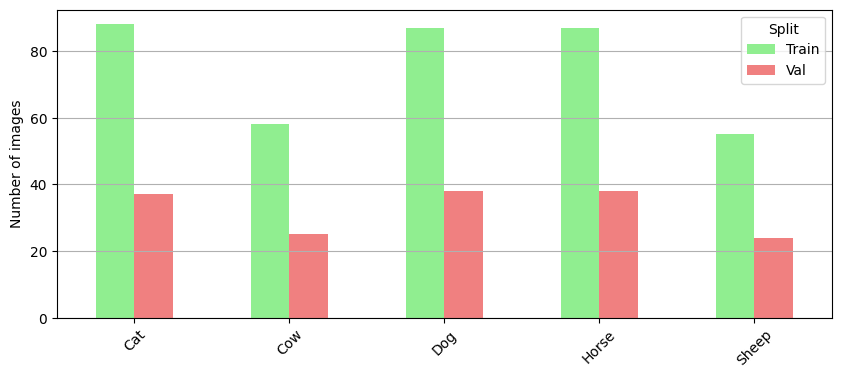

In [34]:
split_cat_counts = df_filter.groupby(['cat', 'split']).size().unstack(fill_value=0)
split_cat_counts.index = split_cat_counts.index.str.capitalize()
split_cat_counts.columns = split_cat_counts.columns.str.capitalize()
split_cat_counts.plot(kind='bar', figsize=(10,4), color=['lightgreen', 'lightcoral'])
plt.xlabel('')
plt.ylabel('Number of images')
plt.xticks(rotation=45)
plt.legend(title='Split')
plt.grid(axis='y')
plt.savefig('images/dataset_splits.png')
plt.show()

# Aspect Ratio Images

In [35]:
df = df_filter

In [36]:
final_ratio = 1.3
height = 360
width = round(final_ratio*height)
final_shape = (width, height)
print(final_shape)

(468, 360)


C:\Users\virgi\AppData\Local\Temp\ipykernel_27628\922880112.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aspect_ratio'] = df['img_w'] / df['img_h']


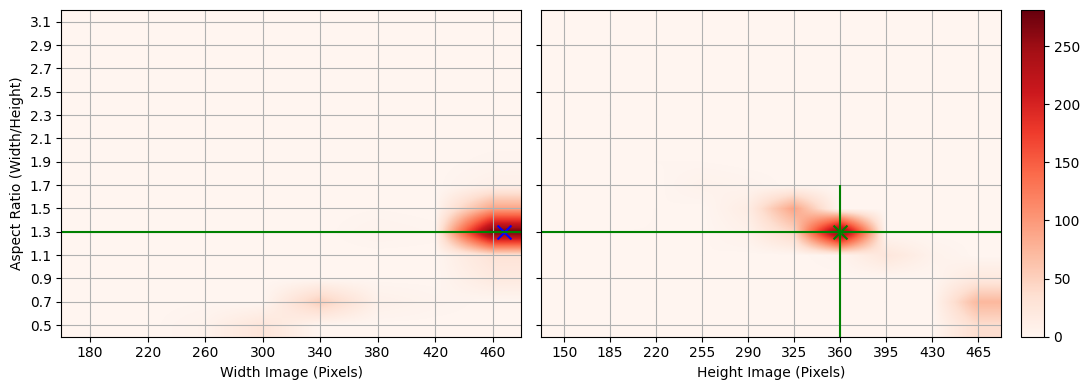

In [37]:
df['aspect_ratio'] = df['img_w'] / df['img_h']

aspect_ratio_bins = np.linspace(round(df['aspect_ratio'].min(), 1), round(df['aspect_ratio'].max(), 1), 15)
width_bins = np.linspace(round(df['img_w'].min() / 10) * 10, round(df['img_w'].max() / 10) * 10, 9)
height_bins = np.linspace(round(df['img_h'].min() / 10) * 10, round(df['img_h'].max() / 10) * 10, 11)

hist_width, xedges, yedges = np.histogram2d(df['img_w'], df['aspect_ratio'], bins=[width_bins, aspect_ratio_bins])
hist_height, xedges_height, yedges_height = np.histogram2d(df['img_h'], df['aspect_ratio'], bins=[height_bins, aspect_ratio_bins])

fig, axes = plt.subplots(1, 3, figsize=(11, 4), gridspec_kw={'width_ratios': [10, 10, 0.5]}) #sharey=True,
im1 = axes[0].imshow(hist_width.T, origin='lower', aspect='auto', cmap='Reds', interpolation='bilinear')
axes[0].set_xlabel('Width Image (Pixels)')
axes[0].set_ylabel('Aspect Ratio (Width/Height)')
axes[0].set_xticks(np.arange(len(xedges) - 1))
axes[0].set_xticklabels(np.int32(xedges[:-1]))
axes[0].set_yticks(np.arange(len(yedges) - 1))
axes[0].set_yticklabels(np.round(yedges[:-1], 1))
axes[0].grid(True)
im2 = axes[1].imshow(hist_height.T, origin='lower', aspect='auto', cmap='Reds', interpolation='bilinear')
axes[1].set_xlabel('Height Image (Pixels)')
#axes[1].set_ylabel('Aspect Ratio (Width/Height)')
axes[1].set_xticks(np.arange(len(xedges_height) - 1))
axes[1].set_xticklabels(np.int32(xedges_height[:-1]))
axes[1].set_yticklabels([])
#axes[1].set_yticks(np.round(np.arange(len(yedges_height) - 1),0))
#axes[1].set_yticklabels(np.round(yedges_height[:-1], 1))
axes[1].grid(True)

#axes[2].axis('off')  # Apagar los ejes de la tercera columna
cbar = fig.colorbar(im1, cax=axes[2], orientation='vertical')#, pad=-0.75)
#cbar.set_ticks([im1.norm.vmin, im1.norm.vmax])  

def get_continuous_bin_position(value, bin_edges):
    idx = np.searchsorted(bin_edges, value) - 1  # Encuentra el bin
    if idx < 0:
        idx = 0
    elif idx >= len(bin_edges) - 1:
        idx = len(bin_edges) - 2
    # Interpolación dentro del bin
    left_edge = bin_edges[idx]
    right_edge = bin_edges[idx + 1]
    position = idx + (value - left_edge) / (right_edge - left_edge)
    return position

width_pos = get_continuous_bin_position(width, xedges)
height_pos = get_continuous_bin_position(height, xedges_height)
ratio_pos_width = get_continuous_bin_position(final_ratio, yedges)
ratio_pos_height = get_continuous_bin_position(final_ratio, yedges_height)
axes[0].scatter(width_pos, ratio_pos_width, color='blue', marker='x', s=100, label='Final Shape')
axes[0].hlines(ratio_pos_width, xmin=axes[0].get_xlim()[0], xmax=axes[0].get_xlim()[1], color='green')
axes[1].scatter(height_pos, ratio_pos_height, color='green', marker='x', s=100, label='Final Shape')
axes[1].hlines(ratio_pos_height, xmin=axes[1].get_xlim()[0], xmax=axes[1].get_xlim()[1], color='green')
axes[1].vlines(height_pos, ymin=axes[1].get_ylim()[0], ymax=height_pos, color='green')

plt.tight_layout()
plt.savefig('images/dataset_ratios.png')
plt.show()

# Parts images

In [38]:
def get_class_name_by_id(class_id):
    for class_name, class_info in part_classes.items():
        if class_info[0] == class_id:
            return class_name  # Retorna el nombre de la clase
    return None  # Si no se encuentra el ID, retorna None

def get_masks(parts, mask):
    parts_mask = np.zeros((mask.shape[0], mask.shape[1], len(part_classes)-1))

    for p in parts:
        p_category = p[0][0]    
        p_cat_id = part_classes[p_category][0]
        p_mask = p[1]
        parts_mask[:,:,p_cat_id-1] = p_mask
        if part_classes[p_category][4] !=None:
            parent_id = part_classes[p_category][4]
            parts_mask[:,:,parent_id-1] = np.maximum(parts_mask[:,:,parent_id-1], p_mask)

    for parent_cat in ['head', 'leg', 'torso']:
        parent_id = part_classes[parent_cat][0]
        children_id = part_classes[parent_cat][5]
        for child_id in children_id:
            parts_mask[:,:,parent_id-1] = np.logical_or(parts_mask[:,:,parent_id-1],parts_mask[:,:,child_id-1])
    
    torso_id = part_classes['torso'][0]
    for parent_cat in ['head', 'leg']:
        parent_id = part_classes[parent_cat][0]
        and_mask = np.logical_and(parts_mask[:,:,parent_id-1],parts_mask[:,:,torso_id-1])
        parts_mask[:,:,torso_id-1] = parts_mask[:,:,torso_id-1]-and_mask
    
    
    parts_mask_parents_plot = np.zeros(mask.shape)
    parts_mask_children_plot = np.zeros(mask.shape)
    for i in range(len(part_classes)-1):
        p_mask = parts_mask[:,:,i]
        p_category = get_class_name_by_id(i+1)
        if part_classes[p_category][4]==None:
            parts_mask_parents_plot = np.maximum(parts_mask_parents_plot,(p_mask*(i+1)))
        else:
            parts_mask_children_plot = np.maximum(parts_mask_children_plot,(p_mask*(i+1)))
    return parts_mask, parts_mask_parents_plot, parts_mask_children_plot

In [39]:
def get_image_plot(part_classes, image, level=1):
    if level==1: #parents
        filtered_part_classes = {key: value for key, value in part_classes.items() if value[4] is None}
        part_colors = [value[3] if value[4] is None else "#000000"  for key,value in part_classes.items() ]
    else:
        filtered_part_classes = {key: value for key, value in part_classes.items() if value[4] is not None}
        part_colors = [value[3] if value[4] is not None else "#000000"  for key,value in part_classes.items() ]
    
    num_classes = len(part_colors)
    cmap = ListedColormap(part_colors)

    bounds = np.arange(num_classes + 1) - 0.5  # Para evitar solapamiento en los bins
    norm = BoundaryNorm(bounds, cmap.N)

    parts_ids = np.unique(image)

    legend_labels = []
    for class_name, class_info in filtered_part_classes.items():
        color = class_info[3]
        if class_info[0] in parts_ids:  # Si la clase está en la máscara
            legend_labels.append(plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=color))
        """
        else:
            # Para las clases ausentes, usar un color más gris o desaturado
            legend_labels.append(plt.Line2D([0], [0], marker='*', color='w', markersize=8, markerfacecolor=color))
        """

    legend_text = [info[1] for info in filtered_part_classes.values()]

    return cmap, norm, legend_labels, legend_text

In [40]:
df.head(20)

,file,split,per_occ,cat,img_w,img_h,aspect_ratio
1,2008_000181,val,0.402376,cat,486,348,1.396552
3,2008_000428,train,0.340494,horse,400,253,1.581028
4,2008_000696,val,0.066217,horse,500,286,1.748252
8,2008_000905,val,0.494438,cow,500,333,1.501502
9,2008_000915,train,0.007621,sheep,500,375,1.333333
12,2008_001137,val,0.176096,dog,375,500,0.750000
14,2008_001278,train,0.300675,horse,400,300,1.333333
15,2008_001285,train,0.120378,dog,500,339,1.474926
20,2008_001592,val,0.106000,cat,500,375,1.333333
23,2008_001836,train,0.069022,cat,500,403,1.240695


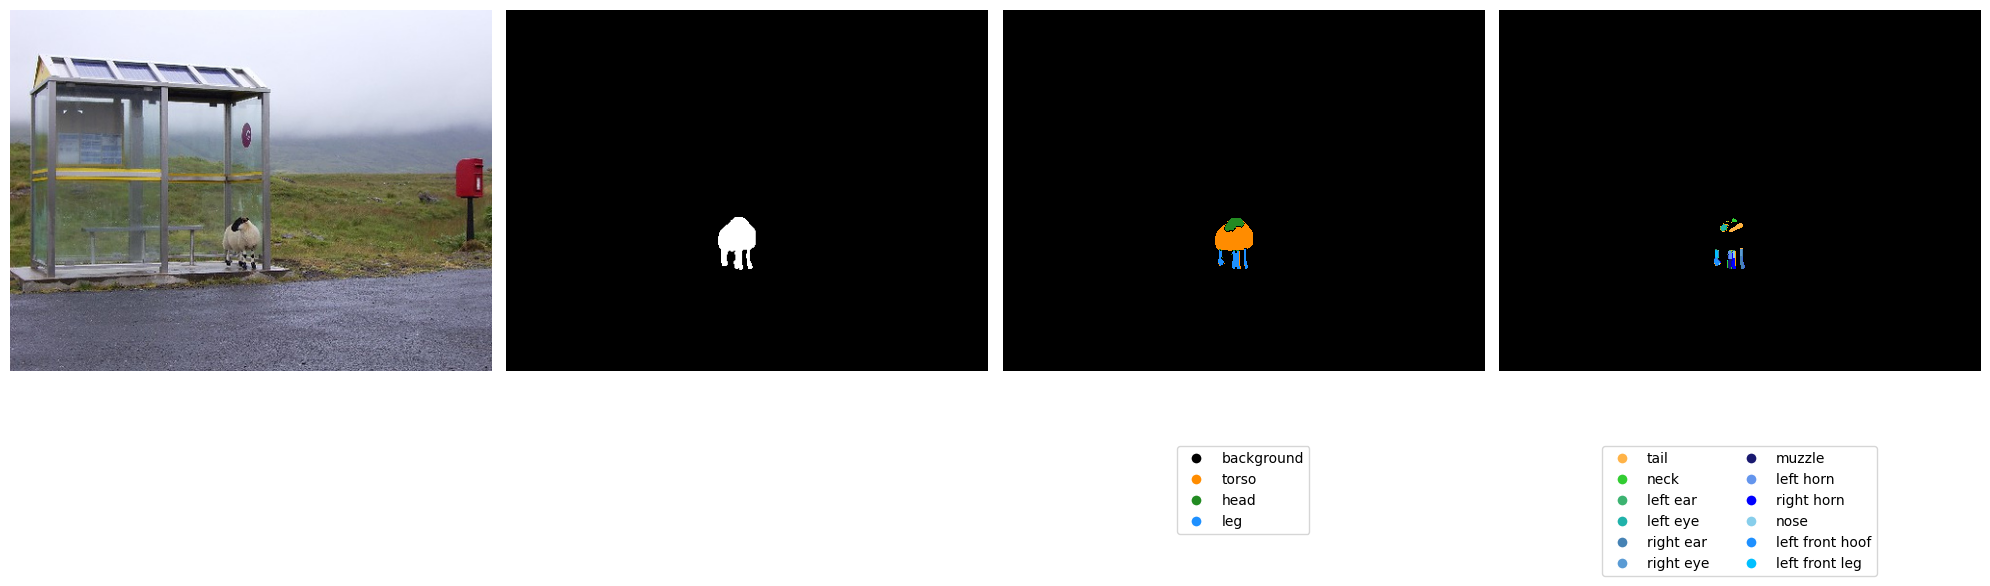

In [41]:
f_name = df.loc[9,'file']
img = cv2.cvtColor(cv2.imread(os.path.join(IMG_PATH_data,f_name+'.jpg')), cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img, final_shape, interpolation=cv2.INTER_LINEAR)

mat_file = loadmat(ANN_PATH_data+f_name+'.mat')
anotations = mat_file['anno'][0][0][1][0][0]
category = anotations[0][0]
mask = anotations[2]
parts = anotations[3][0]
parts_mask, parts_mask_parents_plot, parts_mask_children_plot = get_masks(parts, mask)
resized_mask = cv2.resize(mask, final_shape, interpolation=cv2.INTER_LINEAR)
resized_parts_mask = cv2.resize(parts_mask, final_shape, interpolation=cv2.INTER_LINEAR)
resized_parts_mask_parents_plot = cv2.resize(parts_mask_parents_plot, final_shape, interpolation=cv2.INTER_LINEAR)
resized_parts_mask_children_plot = cv2.resize(parts_mask_children_plot, final_shape, interpolation=cv2.INTER_LINEAR)

fig, axs = plt.subplots(2,4, figsize=(20, 8),gridspec_kw={'height_ratios': [1,0.2]})
axs[0][0].imshow(img)
axs[0][0].axis("off")
axs[1][0].axis("off")
#axs[1].imshow(resized_img)
axs[0][1].imshow(mask, cmap='gray')
axs[0][1].axis("off")
axs[1][1].axis("off")
#axs[3].imshow(parts_mask, cmap='gray')

cmap, norm, legend_labels, legend_text = get_image_plot(part_classes, parts_mask_parents_plot, 1)
axs[0][2].imshow(parts_mask_parents_plot, cmap=cmap, norm=norm)
axs[0][2].axis("off")
axs[1][2].axis("off")
axs[1][2].legend(legend_labels, legend_text, loc="upper center")#, bbox_to_anchor=(1, 0.5))

cmap, norm, legend_labels, legend_text = get_image_plot(part_classes, parts_mask_children_plot, 2)
axs[0][3].imshow(parts_mask_children_plot, cmap=cmap, norm=norm)
axs[0][3].axis("off")
axs[1][3].axis("off")
axs[1][3].legend(legend_labels, legend_text, loc="upper center", ncols=2)#, bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('images/parts_sample_cow.png')
plt.show()

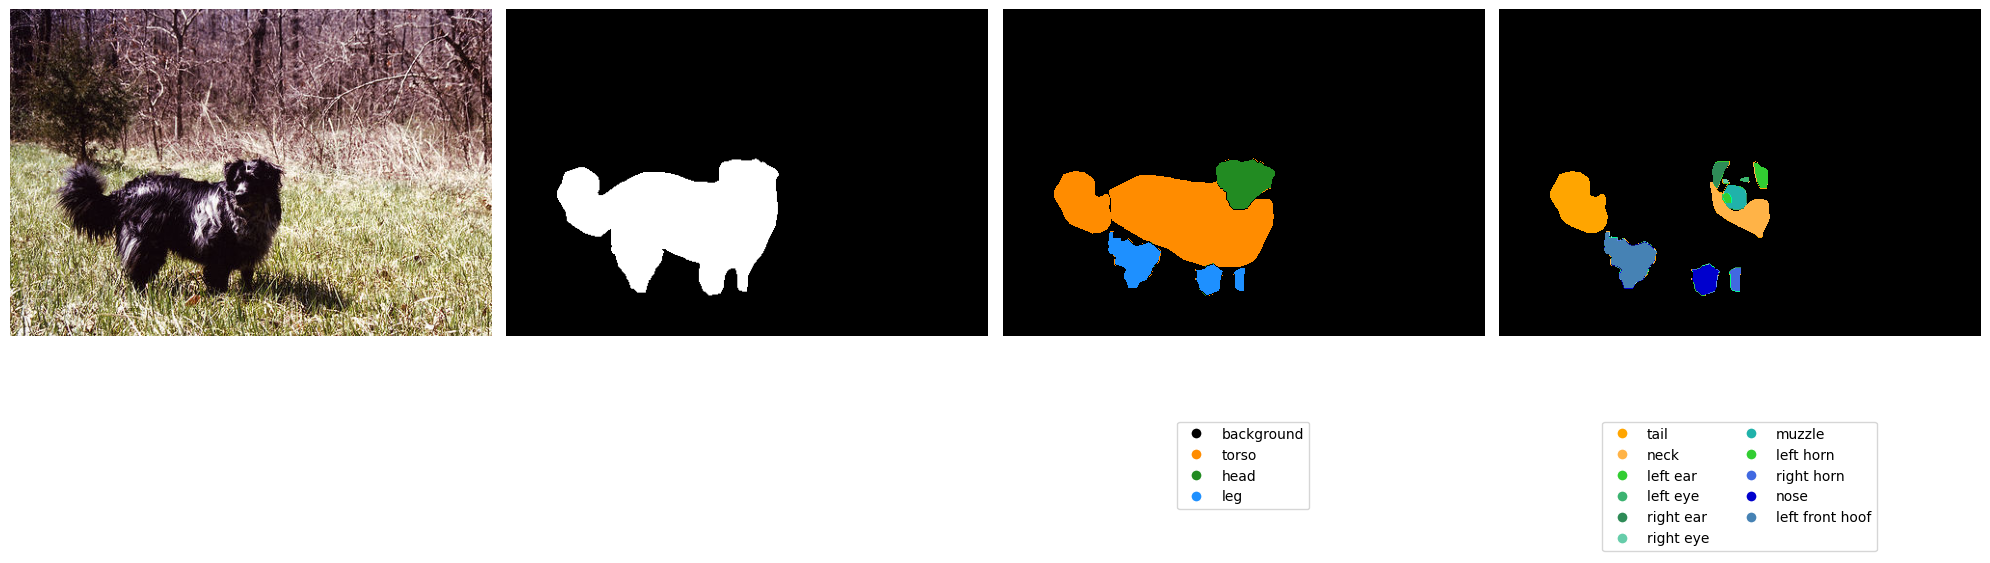

In [42]:
f_name = df.loc[15,'file']
img = cv2.cvtColor(cv2.imread(os.path.join(IMG_PATH_data,f_name+'.jpg')), cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img, final_shape, interpolation=cv2.INTER_LINEAR)

mat_file = loadmat(ANN_PATH_data+f_name+'.mat')
anotations = mat_file['anno'][0][0][1][0][0]
category = anotations[0][0]
mask = anotations[2]
parts = anotations[3][0]
parts_mask, parts_mask_parents_plot, parts_mask_children_plot = get_masks(parts, mask)
resized_mask = cv2.resize(mask, final_shape, interpolation=cv2.INTER_LINEAR)
resized_parts_mask = cv2.resize(parts_mask, final_shape, interpolation=cv2.INTER_LINEAR)
resized_parts_mask_parents_plot = cv2.resize(parts_mask_parents_plot, final_shape, interpolation=cv2.INTER_LINEAR)
resized_parts_mask_children_plot = cv2.resize(parts_mask_children_plot, final_shape, interpolation=cv2.INTER_LINEAR)

fig, axs = plt.subplots(2,4, figsize=(20, 8),gridspec_kw={'height_ratios': [1,0.2]})
axs[0][0].imshow(img)
axs[0][0].axis("off")
axs[1][0].axis("off")
#axs[1].imshow(resized_img)
axs[0][1].imshow(mask, cmap='gray')
axs[0][1].axis("off")
axs[1][1].axis("off")
#axs[3].imshow(parts_mask, cmap='gray')

cmap, norm, legend_labels, legend_text = get_image_plot(part_classes, parts_mask_parents_plot, 1)
axs[0][2].imshow(parts_mask_parents_plot, cmap=cmap, norm=norm)
axs[0][2].axis("off")
axs[1][2].axis("off")
axs[1][2].legend(legend_labels, legend_text, loc="upper center")#, bbox_to_anchor=(1, 0.5))

cmap, norm, legend_labels, legend_text = get_image_plot(part_classes, parts_mask_children_plot, 2)
axs[0][3].imshow(parts_mask_children_plot, cmap=cmap, norm=norm)
axs[0][3].axis("off")
axs[1][3].axis("off")
axs[1][3].legend(legend_labels, legend_text, loc="upper center", ncols=2)#, bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('images/parts_sample_horse.png')
plt.show()

In [43]:
if not os.path.isdir(IMG_RESIZE_PATH_data):
    os.mkdir(IMG_RESIZE_PATH_data)
if not os.path.isdir(ANN_RESIZE_PATH_data):
    os.mkdir(ANN_RESIZE_PATH_data)   

df['per_occ_torso'] = np.nan
df['per_occ_head'] = np.nan
df['per_occ_leg'] = np.nan

img_pixels = final_shape[0]*final_shape[1]

for index, row in df.iterrows():
    f_name = row['file']
    img = cv2.cvtColor(cv2.imread(os.path.join(IMG_PATH_data,f_name+'.jpg')), cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(img, final_shape, interpolation=cv2.INTER_LINEAR)
    cv2.imwrite(os.path.join(IMG_RESIZE_PATH_data,f_name+'.jpg'), cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
    
    mat_file = loadmat(ANN_PATH_data+f_name+'.mat')
    anotations = mat_file['anno'][0][0][1][0][0]
    category = anotations[0][0]
    mask = anotations[2]
    resized_mask = cv2.resize(mask, final_shape, interpolation=cv2.INTER_LINEAR)
    cv2.imwrite(os.path.join(ANN_RESIZE_PATH_data,f_name+'_mask.png'), resized_mask*255)

    df.loc[index, 'per_occ'] = np.count_nonzero(resized_mask)/img_pixels
    if len(anotations[3])>0:
        parts = anotations[3][0]
        parts_mask, parts_mask_parents_plot, parts_mask_children_plot = get_masks(parts, mask)
        resized_parts_mask = cv2.resize(parts_mask, final_shape, interpolation=cv2.INTER_LINEAR)
        np.save(os.path.join(ANN_RESIZE_PATH_data,f_name+'_parts.npy'), resized_parts_mask)

        torso_id = part_classes['torso'][0]
        df.loc[index, 'per_occ_torso'] = np.count_nonzero(resized_parts_mask[:,:,torso_id-1])/img_pixels
        head_id = part_classes['head'][0]
        df.loc[index, 'per_occ_head'] = np.count_nonzero(resized_parts_mask[:,:,head_id-1])/img_pixels
        leg_id = part_classes['leg'][0]
        df.loc[index, 'per_occ_leg'] = np.count_nonzero(resized_parts_mask[:,:,leg_id-1])/img_pixels

df.to_csv('dataset_info_parts.csv', index=False)

C:\Users\virgi\AppData\Local\Temp\ipykernel_27628\1434163392.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['per_occ_torso'] = np.nan
C:\Users\virgi\AppData\Local\Temp\ipykernel_27628\1434163392.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['per_occ_head'] = np.nan
C:\Users\virgi\AppData\Local\Temp\ipykernel_27628\1434163392.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

# Percentage Occupation

In [44]:
data = pd.read_csv('dataset_info_parts.csv')

In [45]:
data.head()

,file,split,per_occ,cat,img_w,img_h,aspect_ratio,per_occ_torso,per_occ_head,per_occ_leg
0,2008_000181,val,0.402000,cat,486,348,1.396552,0.333280,0.056689,0.017788
1,2008_000428,train,0.339666,horse,400,253,1.581028,0.238420,0.027095,0.086978
2,2008_000696,val,0.065753,horse,500,286,1.748252,0.032134,0.014156,0.022068
3,2008_000905,val,0.494171,cow,500,333,1.501502,0.184247,0.317854,0.000000
4,2008_000915,train,0.007461,sheep,500,375,1.333333,0.005027,0.001193,0.002018


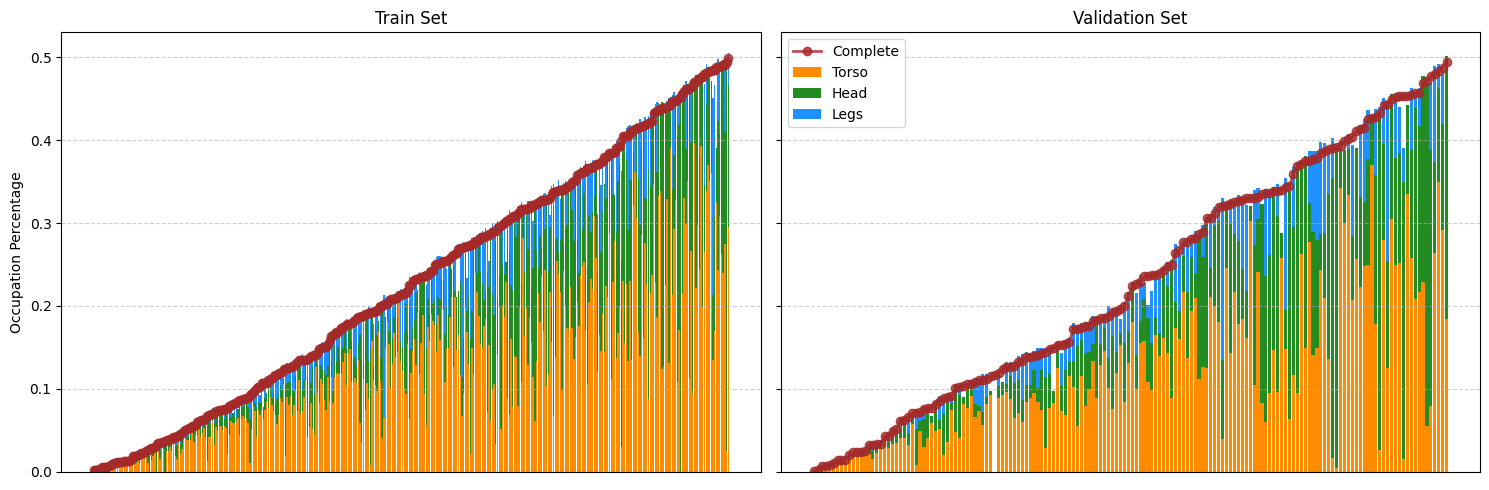

In [46]:
train_data = data[data['split'] == 'train'].sort_values(by='per_occ', ascending=True).reset_index(drop=True)
val_data = data[data['split'] == 'val'].sort_values(by='per_occ', ascending=True).reset_index(drop=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
def plot_split_data(ax, data_split, title):
    bottom_torso = data_split['per_occ_torso']
    bottom_head = bottom_torso + data_split['per_occ_head']
    ax.plot(data_split.index, data_split['per_occ'], marker='o', linestyle='-', color='brown', label='Complete', linewidth=2, alpha=0.8)
    ax.bar(data_split.index, data_split['per_occ_torso'], color=part_classes['torso'][3], label='Torso')
    ax.bar(data_split.index, data_split['per_occ_head'], color=part_classes['head'][3], bottom=bottom_torso, label='Head')
    ax.bar(data_split.index, data_split['per_occ_leg'], color=part_classes['leg'][3], bottom=bottom_head, label='Legs')
    ax.set_title(title)
    ax.set_xticks([])
    ax.grid(True, linestyle='--', alpha=0.6)

plot_split_data(axes[0], train_data, 'Train Set')
plot_split_data(axes[1], val_data, 'Validation Set')
axes[0].set_ylabel('Occupation Percentage')
plt.legend()
plt.tight_layout()
plt.savefig('images/parts_occupation.png')
plt.show()